In [1]:
# from skimage.exposure import histogram
# import rasterio
# from rasterio.plot import show

# image = "scratch/cropped_N4W351.tif"
# raster = rasterio.open(image)

In [2]:
geotiff = "scratch/cropped_N4W351.tif"

In [3]:
import rasterio
import numpy as np
import geopandas as gpd
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from rasterio.plot import show
from sklearn.cluster import KMeans
from samgeo import overlay_images

import os
import cv2
import numpy as np
import shapely
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt


image = rasterio.open(geotiff)

red = image.read(1).astype(float)
green = image.read(2).astype(float)
blue = image.read(3).astype(float)
nir = image.read(4).astype(float)
bands = np.dstack((red, green, blue, nir))
nbands = image.read().shape[0]

ndvi = (nir - red) / (nir + red)
ndvi[np.isnan(ndvi)] = 0
open_spaces = ndvi < 0.1



/var/folders/9m/53rx94xs2097p0tn8zyxhkxr0000gn/T/ipykernel_15415/3102707821.py:28: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


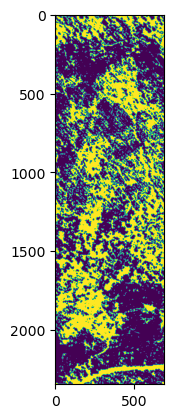

<Axes: >

In [4]:
show(open_spaces, cmap='viridis')

In [5]:
def array_to_image(
    array, output, source=None, dtype=None, compress="deflate", **kwargs
):
    """Save a NumPy array as a GeoTIFF using the projection information from an existing GeoTIFF file.

    Args:
        array (np.ndarray): The NumPy array to be saved as a GeoTIFF.
        output (str): The path to the output image.
        source (str, optional): The path to an existing GeoTIFF file with map projection information. Defaults to None.
        dtype (np.dtype, optional): The data type of the output array. Defaults to None.
        compress (str, optional): The compression method. Can be one of the following: "deflate", "lzw", "packbits", "jpeg". Defaults to "deflate".
    """

    from PIL import Image

    if isinstance(array, str) and os.path.exists(array):
        array = cv2.imread(array)
        array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)

    if output.endswith(".tif") and source is not None:
        with rasterio.open(source) as src:
            crs = src.crs
            transform = src.transform
            if compress is None:
                compress = src.compression

        # Determine the minimum and maximum values in the array

        min_value = np.min(array)
        max_value = np.max(array)

        if dtype is None:
            # Determine the best dtype for the array
            if min_value >= 0 and max_value <= 1:
                dtype = np.float32
            elif min_value >= 0 and max_value <= 255:
                dtype = np.uint8
            elif min_value >= -128 and max_value <= 127:
                dtype = np.int8
            elif min_value >= 0 and max_value <= 65535:
                dtype = np.uint16
            elif min_value >= -32768 and max_value <= 32767:
                dtype = np.int16
            else:
                dtype = np.float64

        # Convert the array to the best dtype
        array = array.astype(dtype)

        # Define the GeoTIFF metadata
        if array.ndim == 2:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": 1,
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }
        elif array.ndim == 3:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": array.shape[2],
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }

        if compress is not None:
            metadata["compress"] = compress
        else:
            raise ValueError("Array must be 2D or 3D.")

        # Create a new GeoTIFF file and write the array to it
        with rasterio.open(output, "w", **metadata) as dst:
            if array.ndim == 2:
                dst.write(array, 1)
            elif array.ndim == 3:
                for i in range(array.shape[2]):
                    dst.write(array[:, :, i], i + 1)

    else:
        img = Image.fromarray(array)
        img.save(output, **kwargs)

In [6]:
mask = "open_spaces.tif"
array_to_image(open_spaces, mask, source=geotiff)


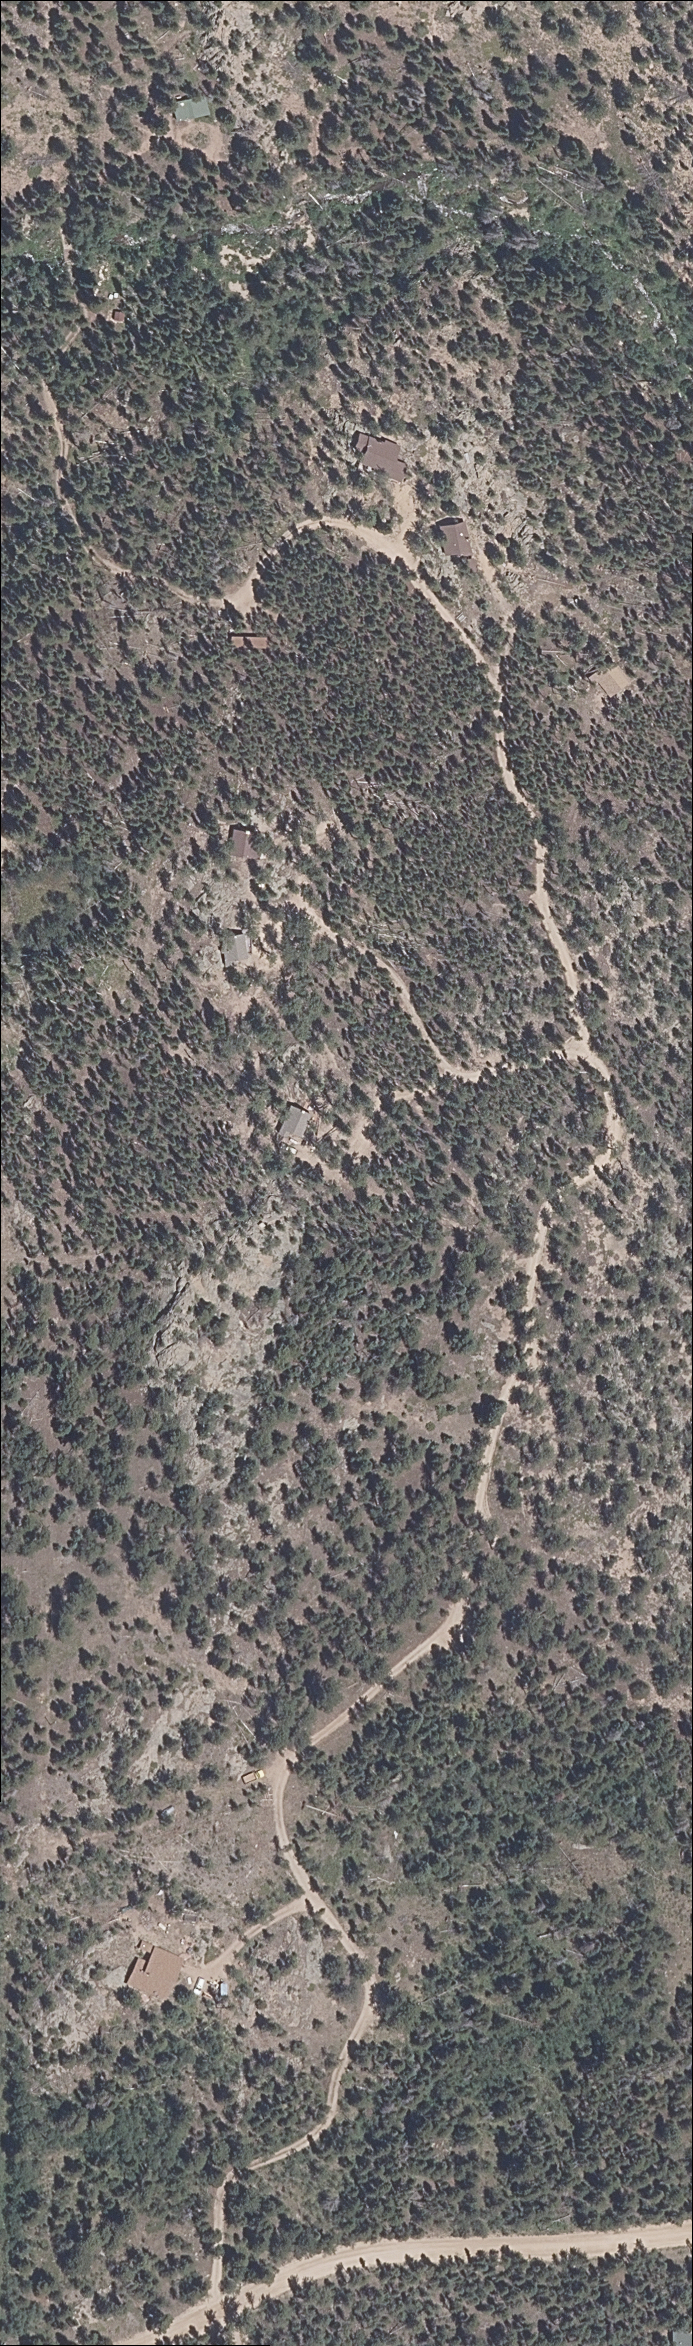
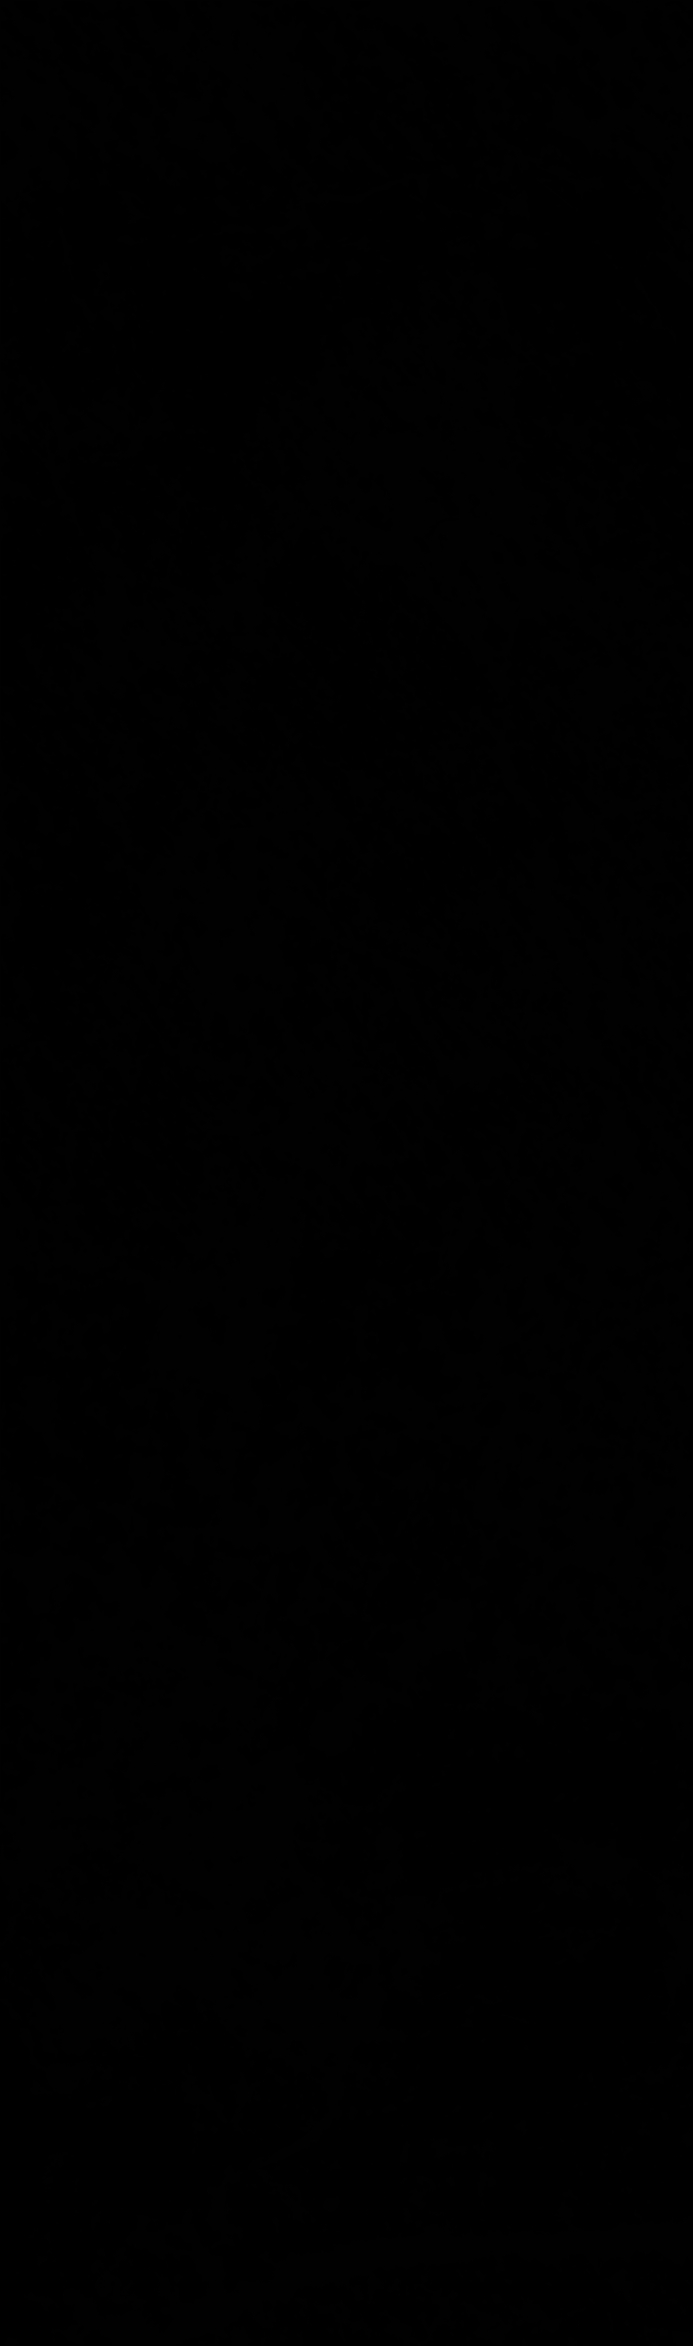

In [7]:
import leafmap
from ipyleaflet import Map

leafmap.image_comparison(
    geotiff,
    mask,
    label1="Image",
    label2="Image Segmentation",
)

In [8]:
overlay_images(geotiff, mask, backend="TkAgg")